<h1>🏆 Image Generation using Diffusion Models</h1>

Estimated time for completion: 90 minutes on a T4 using Google Collab.

<h2>Part 1: Understanding Diffusion Models</h2>

1. What are diffusion models?

Diffusion models are generative models that learn to generate data by reversing a gradual noising process.
They work by slowly adding random noise to data in a forward process, and then learning to reverse this
process to recover the original data distribution. Unlike GANs or VAEs, diffusion models use a sequence
of denoising steps, making them more stable to train but potentially slower to sample from.

In this challenge, you will learn about one of the most popular type of diffusion models called Denoising Diffusion Probabilistic Models, commonly known as DDPMs, which were introduced  originally in this [NeuRIPS paper](https://arxiv.org/pdf/2006.11239) in 2020 and has been the foundation for cutting-edge image generation systems, including DALL-E 2, Imagen, Stable Diffusion and Midjourney.

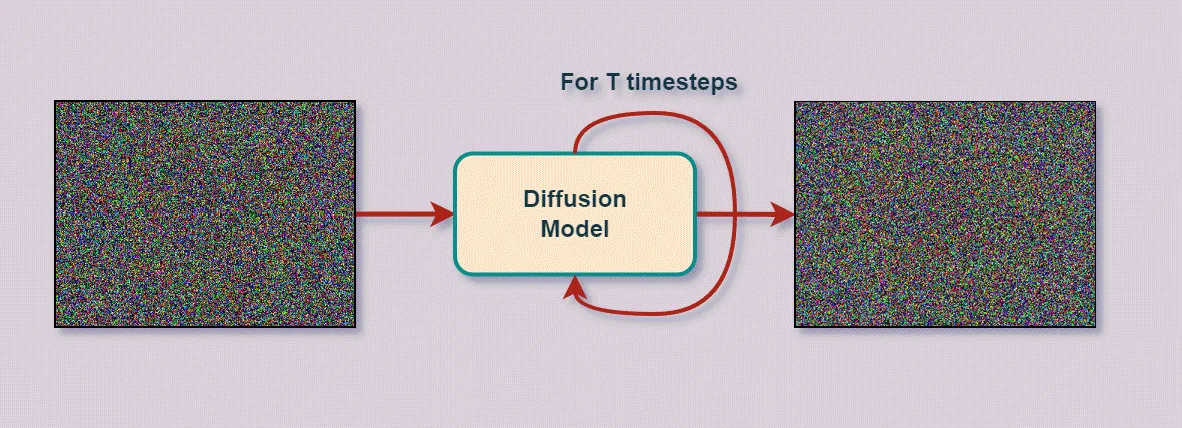

2. Forward diffusion process: ⬅️

The forward diffusion process gradually adds Gaussian noise to an image over T timesteps according to a
predefined noise schedule. At each step t, some portion of the original signal is preserved while new noise
is added. As t increases, the image becomes more noisy until at t=T, it approaches a pure Gaussian noise
distribution. Mathematically, this is defined as $q(x_t|x_{t-1})$ and is the "transition function" applied at each step in the **forward diffusion process**, where each step adds a small amount of
Gaussian noise according to variance $\beta_t$.


How do we get image $x_t$ from $x_{t-1}$?

We can easily sample iamge $x_t$ from a normal distribution as follows:
\begin{align}
x_t = x_{t-1} \sqrt{(1-\beta_t)} + \epsilon \sqrt{\beta_t}  \\ \text{where} \epsilon \sim N(0, I)
\end{align}


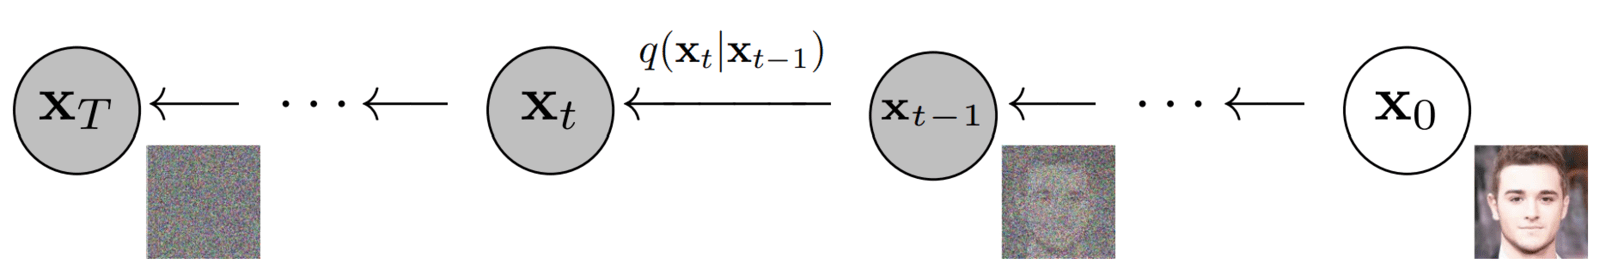

In practice, the authors of DDPMs use a "linear variance scheduler" and define $\beta$ in the range of $[0.0001, 0.02]$ and set the total timesteps to $T=1000$. With beta values between 0.0001 and 0.02, it takes many timesteps (typically 1000 or more) for the data to become close to pure noise. If beta values were larger, the process would reach pure noise much more quickly, potentially limiting the model's ability to learn the detailed structure of the data distribution.


**Sampling at any timestep**

In order to be able to sample at any timesteps and avoid sampling $t$ times to obtain $x_t$, the authors introduce two extra terms:
$$\alpha_t = 1-\beta_t \quad \quad (1)$$
$$\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s \quad \quad (2)$$
where equation (2) is the cumulative product of $\alpha_t$ from $1$ to $t$.

Now, we can sample $x_t$ directly instead of having to perform $t$ sampling steps:

$$x_t = x_0 \sqrt{\bar{\alpha}_t} + \epsilon \sqrt{(1-\bar{\alpha}_t)}$$

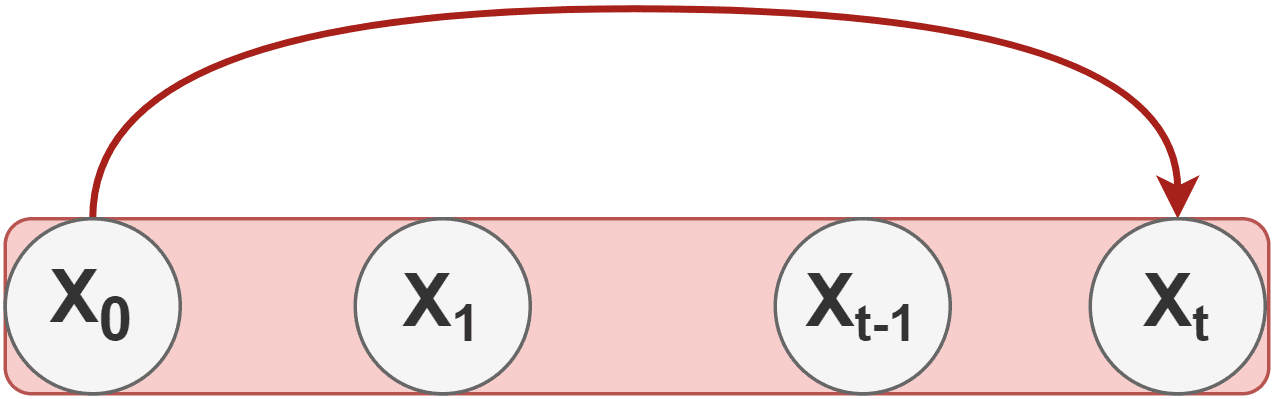




3. Reverse diffusion process (sampling): ➡️

The reverse diffusion process (sampling) starts with a pure noise sample $x_T \sim N(0,I)$ and gradually denoises
it over T steps to generate a sample from the data distribution. At each step, the model predicts the noise
component in the current noisy image, then uses this prediction to compute a slightly less noisy image for
the next step. This process continues until we reach $x_0$, which should resemble a sample from the original
data distribution. Mathematically, this is defined as $p_{\theta}(x_{t-1}|x_t)$ and is the "transition function" applied at each step in the **reverse diffusion process**. In our case, we'll get fashion items like clothing and shoes.


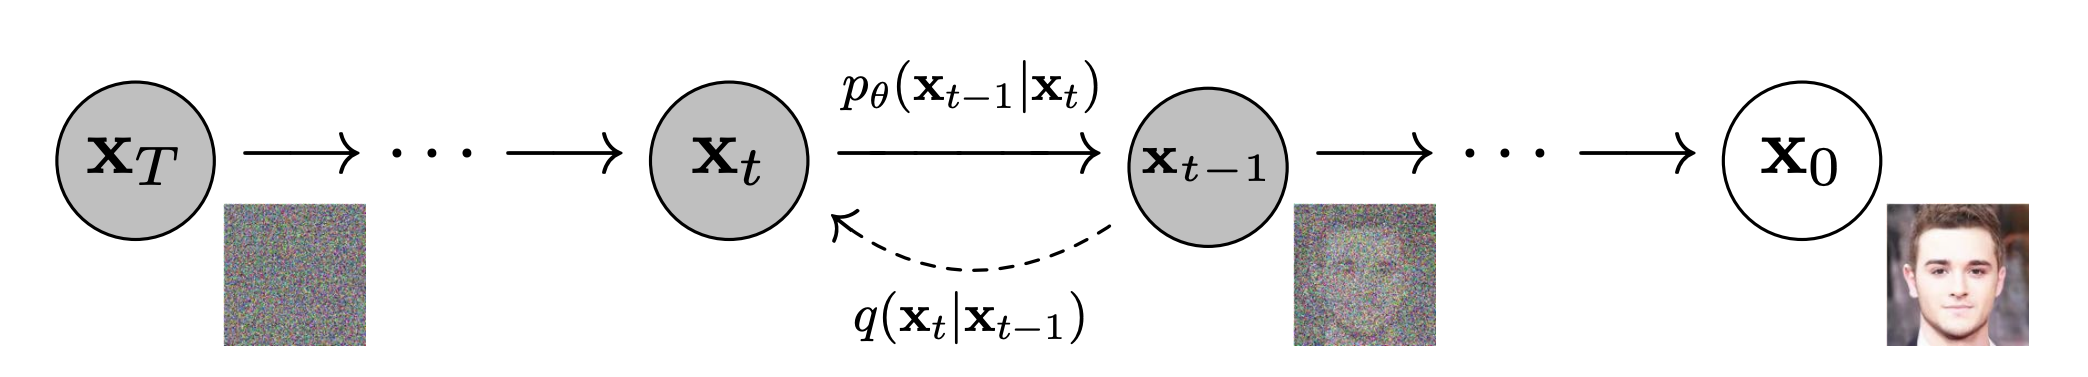


4. What does the neural network in DDPM actually learn to predict?

The neural network in DDPM learns to predict the noise $\epsilon$ that was added to the image at a particular timestep $t$: $$\epsilon_{\theta}(x_t,t)$$

The training objective of the U-Net that predicts noise in DDPMs is:

$$
\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}, t) \|^2 \right]
$$

where:
- $\boldsymbol{\epsilon} \sim N(0, \mathbf{I})$ is the random noise added.
- $\boldsymbol{\epsilon}_\theta$ is the U-Net model with parameters $\theta$ that predicts the noise.
- $t$ is sampled uniformly from \{1, 2, ... T\}.
- $x_0$ is the original image.
- $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$ and $\alpha_i = 1 - \beta_i$.
- \beta_i is the noise schedule parameter at step $i$.

This objective trains the U-Net to predict the noise $\boldsymbol{\epsilon}$
that was added to create the noisy sample $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

In practice, given an image $x_0$, a timestep $t$ is sampled, and the U-Net model predicts the added noise from timestep $t-1$ to $t$.


<h3>Recap:<h3>

The following two algorithms from the original paper summarize the training and sampling processes:
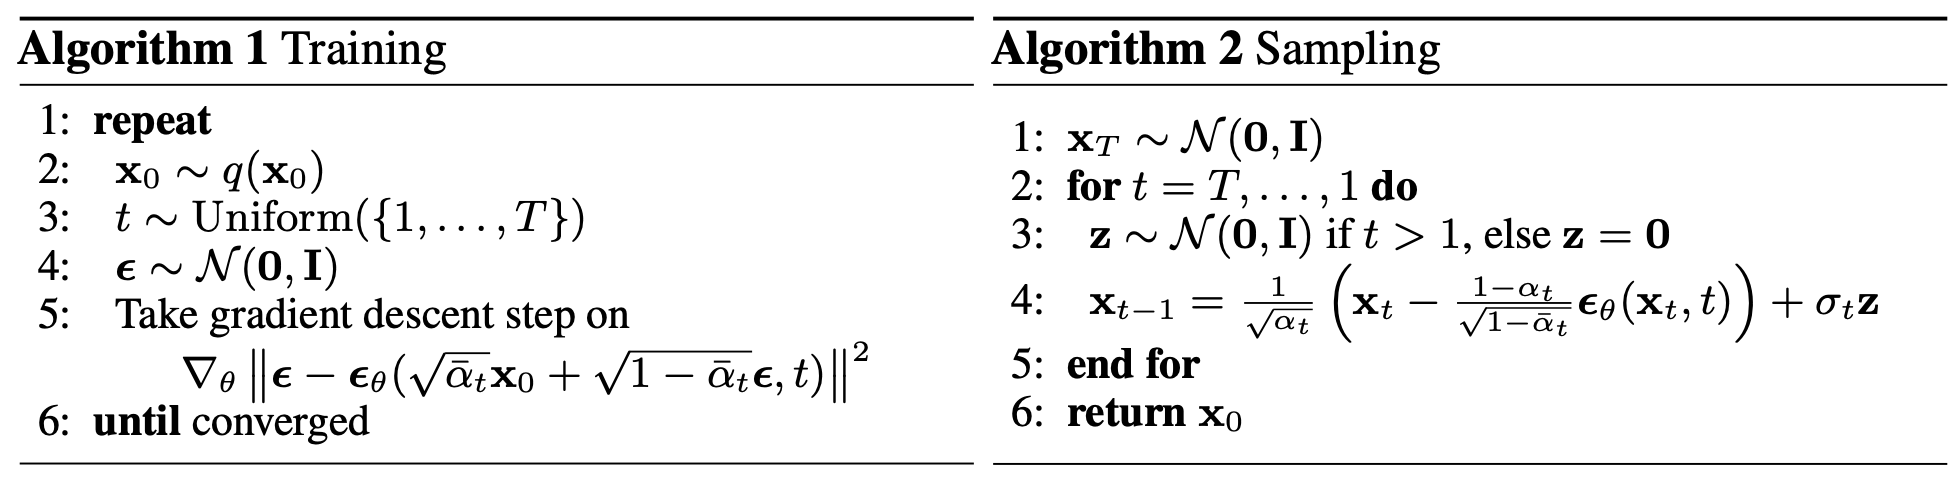


<h2>Part 2: Implementing DDPMs</h2>

In this part, we will train a DDPMs to generate images from Fashion MNIST, a dataset of different clothes. This dataset is small and versatile, which makes it perfect for training a DDPM from scratch under 1 hour.


In [1]:
# DDPM Challenge: Generate Your Own Fashion Items

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ---------------------------------------------------
# Part 2: Load and Visualize the MNIST Dataset
# ---------------------------------------------------

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (1.0,))  # Normalize to [-1, 1]
])

# Load Fashion MNIST dataset
train_dataset = FashionMNIST('./data', train=True, download=True, transform=transform)

# Fashion MNIST classes
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.86MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.3MB/s]


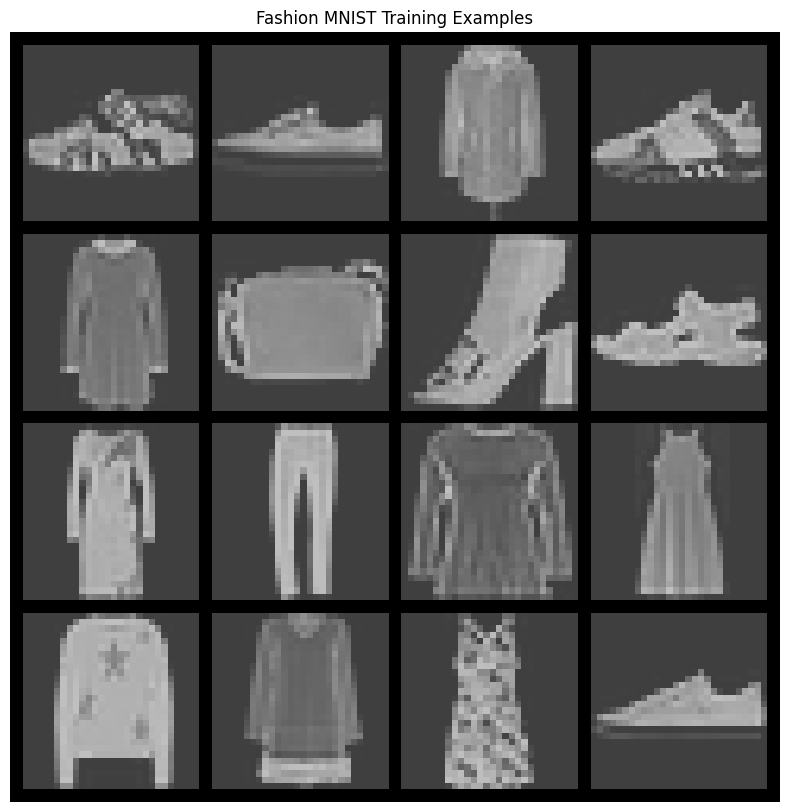

In [3]:

# Visualize some examples
def show_images(images, title="", labels=None):
    """Display a batch of images."""
    plt.figure(figsize=(10, 10))

    # Unnormalize the images
    images = (images + 1) / 2

    # Create a grid of images
    grid = make_grid(images[:16], nrow=4).permute(1, 2, 0)
    plt.imshow(grid.cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# Display some training examples
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, "Fashion MNIST Training Examples", labels)


**TODO:**


Define the DDPM Noise Schedule, given a starting and ending value for $beta_t$, fill the function *ddpm_schedules* to return a dictionnary with tensors of length T containing variables that we will be using later:

- "beta_t": $\beta_t$
- "alpha_t": $\alpha_t=1-\beta_t$
- "oneover_sqrta": $\frac{1}{\sqrt{\alpha_t}}$
- "sqrt_beta_t": $\sqrt{\beta_t}$
- "alphabar_t": $\bar{\alpha}_t$
- "sqrtab": $\sqrt{\bar{\alpha}_t}$
- "sqrtmab": $\sqrt{(1-\bar{\alpha}_t)}$
- "mab_over_sqrtmab": $(1-\alpha_t) / \sqrt{(1-\bar{\alpha}_t)}$


In [4]:
# ---------------------------------------------------
# Part 3: Define the DDPM Noise Schedule
# ---------------------------------------------------

def ddpm_schedules(beta1: float, beta2: float, T: int, device: str = 'cpu') -> dict:
    """
    Returns pre-computed schedules for DDPM sampling, training process.

    Args:
        beta1: Start value for the noise schedule
        beta2: End value for the noise schedule
        T: Number of diffusion steps

    Returns:
        A dictionary of useful values for the diffusion process
    """
    # Noise schedule
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32, device=device) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)

    # Alpha schedule
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    # Other useful quantities
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return {
        "beta_t": beta_t,  # β_t
        "alpha_t": alpha_t,  # α_t
        "oneover_sqrta": oneover_sqrta,  # 1/√α_t
        "sqrt_beta_t": sqrt_beta_t,  # √β_t
        "alphabar_t": alphabar_t,  # ᾱ_t
        "sqrtab": sqrtab,  # √ᾱ_t
        "sqrtmab": sqrtmab,  # √(1-ᾱ_t)
        "mab_over_sqrtmab": mab_over_sqrtmab,  # (1-α_t)/√(1-ᾱ_t)
    }

Noise schedule computed successfully!


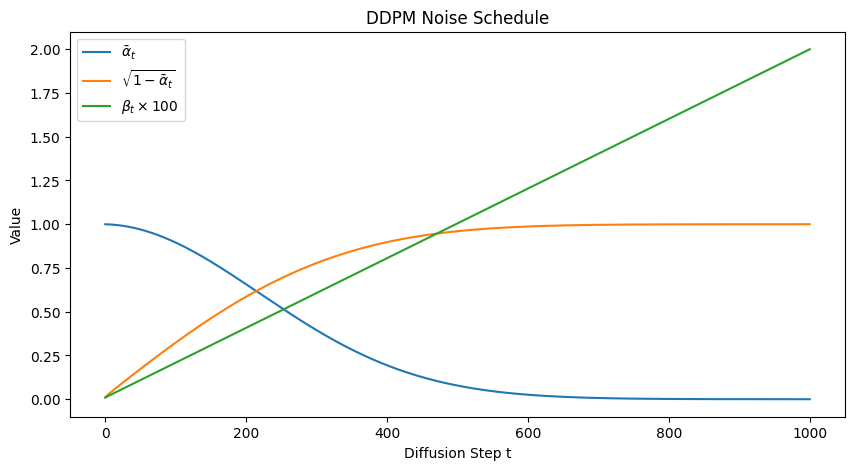

In [10]:
# Test our implementation
test_schedules = ddpm_schedules(1e-4, 0.02, 1000, device=device)
print("Noise schedule computed successfully!")

# Plot the noise schedule to visualize it
plt.figure(figsize=(10, 5))
plt.plot(test_schedules["alphabar_t"].cpu().numpy(), label=r'$\bar{\alpha}_t$')
plt.plot(test_schedules["sqrtmab"].cpu().numpy(), label=r'$\sqrt{1-\bar{\alpha}_t}$')
plt.plot(test_schedules["beta_t"].cpu().numpy() * 100, label=r'$\beta_t \times 100$')
plt.legend()
plt.title("DDPM Noise Schedule")
plt.xlabel("Diffusion Step t")
plt.ylabel("Value")
plt.show()


**TODO:**

Implement the forward diffusion process.

Add noise according to the schedule:

$$x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε$$

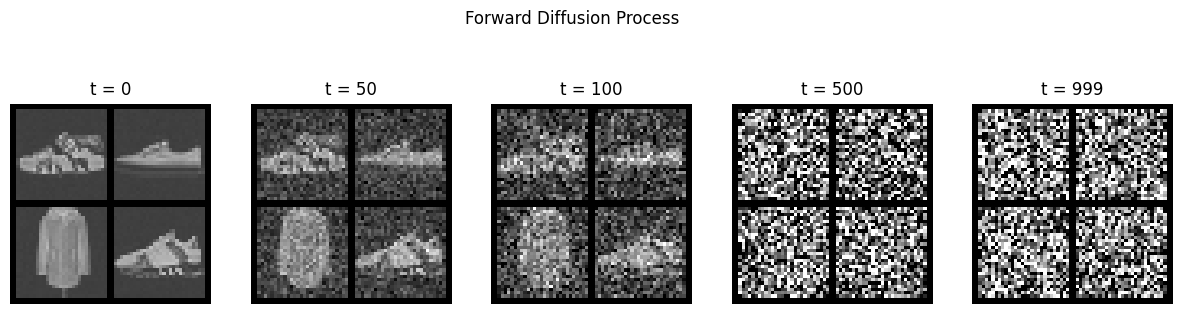

In [6]:
# ---------------------------------------------------
# Part 4: Implement the Forward Diffusion Process
# ---------------------------------------------------

def forward_diffusion(x0, t, schedules):
    """
    Forward diffusion process: q(x_t | x_0)
    Gradually adds noise to an image according to the noise schedule.

    Args:
        x0: Initial image (clean)
        t: Timestep(s) for which to add noise
        schedules: Dictionary of pre-computed diffusion values

    Returns:
        x_t: Noisy image at timestep t
        noise: The noise that was added
    """
    # Generate random noise
    noise = torch.randn_like(x0)

    # Add noise according to the schedule
    # x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε
    x_t = schedules["sqrtab"][t, None, None, None] * x0 + schedules["sqrtmab"][t, None, None, None] * noise

    return x_t, noise

# Test the forward diffusion process
x0 = images[:4].to(device)  # Use 4 images for testing
timesteps = [0, 50, 100, 500, 999]  # Test at different diffusion steps

plt.figure(figsize=(15, 4))
for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], device=device).repeat(x0.shape[0])
    x_t, _ = forward_diffusion(x0, t_tensor, test_schedules)

    # Display the noisy image
    plt.subplot(1, len(timesteps), i+1)
    grid = make_grid((x_t + 1)/2, nrow=2).permute(1, 2, 0)
    plt.imshow(grid.cpu().numpy(), cmap='gray')
    plt.title(f"t = {t}")
    plt.axis('off')
plt.suptitle("Forward Diffusion Process")
plt.show()

In [7]:
# ---------------------------------------------------
# Part 5: Define the Epsilon Prediction Model
# ---------------------------------------------------

# Define a simple convolutional block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

# Create a simpler model for faster training
class UNet(nn.Module):
    """
    Simplified model that predicts the noise added at each step.
    """
    def __init__(self, n_channels=1):
        super(UNet, self).__init__()

        # Simple convolutional neural network
        self.conv = nn.Sequential(
            conv_block(n_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 128),
            conv_block(128, 64),
            nn.Conv2d(64, n_channels, 3, padding=1),
        )

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
        )

    def forward(self, x, t):
        # Process the input
        features = self.conv(x)

        # Embed time and broadcast
        t_emb = self.time_embed(t.unsqueeze(-1))
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)

        # Combine time embedding with features
        # Just adding a small influence from the time embedding
        return features + 0.1 * t_emb.mean(dim=1, keepdim=True)

# Initialize the model
model = UNet().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 748801 parameters


**TODO:**

Implement the DDPM Training and Sampling.


In [8]:
# ---------------------------------------------------
# Part 6: Implement the DDPM Training and Sampling
# ---------------------------------------------------

class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model.
    """
    def __init__(self, eps_model, betas, n_T, criterion=nn.MSELoss()):
        super(DDPM, self).__init__()
        self.eps_model = eps_model
        self.n_T = n_T
        self.criterion = criterion

        # Register noise schedule
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

    def forward(self, x):
        """
        Training forward pass. Equivalent to one step of Algorithm 1 in the DDPM paper.
        """
        # Sample random timesteps (batch_size,)
        t = torch.randint(1, self.n_T + 1, (x.shape[0],), device=x.device)

        # Add noise to the input
        noise = torch.randn_like(x)
        x_t = self.sqrtab[t, None, None, None] * x + self.sqrtmab[t, None, None, None] * noise

        # Predict the noise
        predicted_noise = self.eps_model(x_t, t / self.n_T)

        # Calculate loss
        loss = self.criterion(noise, predicted_noise)

        return loss

    def sample(self, n_sample, size, device, return_intermediate_steps=False):
        """
        Sampling function. Equivalent to Algorithm 2 in the DDPM paper.
        """
        # Start with random noise
        x = torch.randn(n_sample, *size).to(device)
        intermediate_steps = []
        # Iteratively denoise
        for i in tqdm(range(self.n_T, 0, -1), desc="Sampling"):
            # Get the current timestep
            t_norm = i / self.n_T

            # Predict the noise
            predicted_noise = self.eps_model(x, torch.ones(n_sample, device=device) * t_norm)

            # If not the last step, add some noise (stochasticity)
            z = torch.randn_like(x) if i > 1 else 0

            # Update x using the predicted noise and schedules
            x = (
                self.oneover_sqrta[i] * (x - predicted_noise * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if return_intermediate_steps:
                intermediate_steps.append(x.clone())
        if return_intermediate_steps:
            return x, intermediate_steps
        return x

Epoch 1/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/60, Loss: 0.080171


Epoch 2/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/60, Loss: 0.051118


Epoch 3/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/60, Loss: 0.047456


Epoch 4/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/60, Loss: 0.043610


Epoch 5/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/60, Loss: 0.042670


Epoch 6/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/60, Loss: 0.041097


Epoch 7/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/60, Loss: 0.039591


Epoch 8/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/60, Loss: 0.039235


Epoch 9/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/60, Loss: 0.038617


Epoch 10/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/60, Loss: 0.037418


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

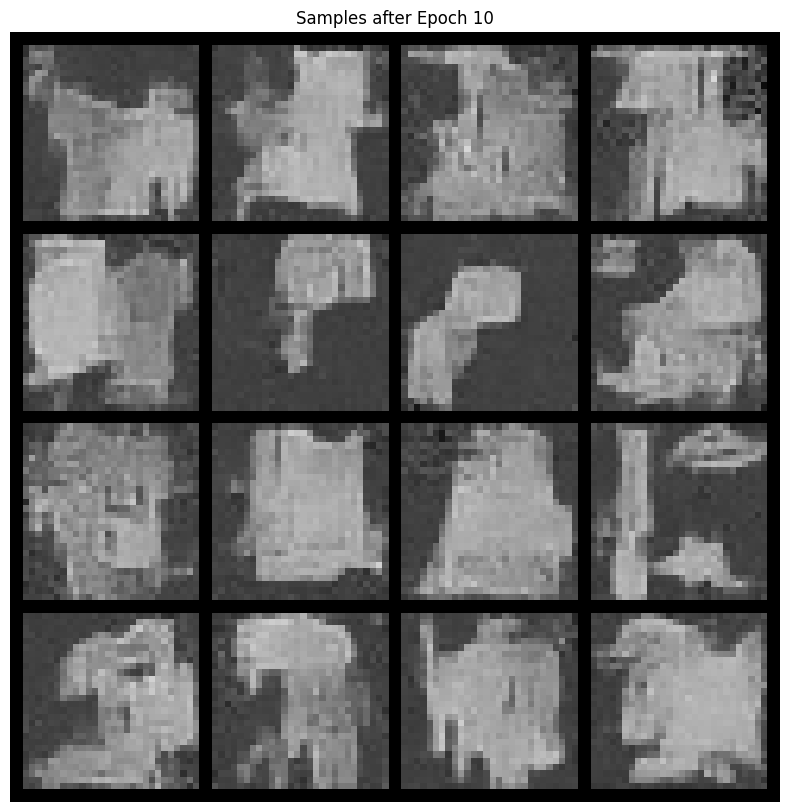

Epoch 11/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/60, Loss: 0.037287


Epoch 12/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/60, Loss: 0.036772


Epoch 13/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/60, Loss: 0.036331


Epoch 14/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/60, Loss: 0.036473


Epoch 15/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/60, Loss: 0.035635


Epoch 16/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/60, Loss: 0.035525


Epoch 17/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/60, Loss: 0.035513


Epoch 18/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/60, Loss: 0.035144


Epoch 19/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/60, Loss: 0.035552


Epoch 20/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/60, Loss: 0.034903


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

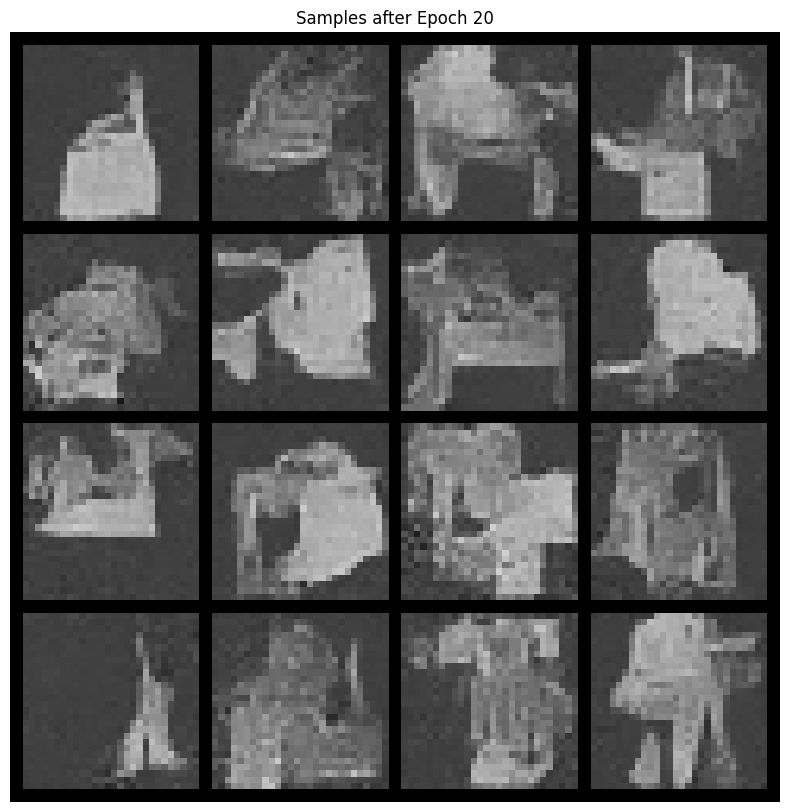

Epoch 21/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/60, Loss: 0.034554


Epoch 22/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/60, Loss: 0.034661


Epoch 23/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/60, Loss: 0.034678


Epoch 24/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/60, Loss: 0.034214


Epoch 25/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/60, Loss: 0.034029


Epoch 26/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/60, Loss: 0.033759


Epoch 27/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/60, Loss: 0.033806


Epoch 28/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/60, Loss: 0.033381


Epoch 29/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/60, Loss: 0.033709


Epoch 30/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/60, Loss: 0.033569


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

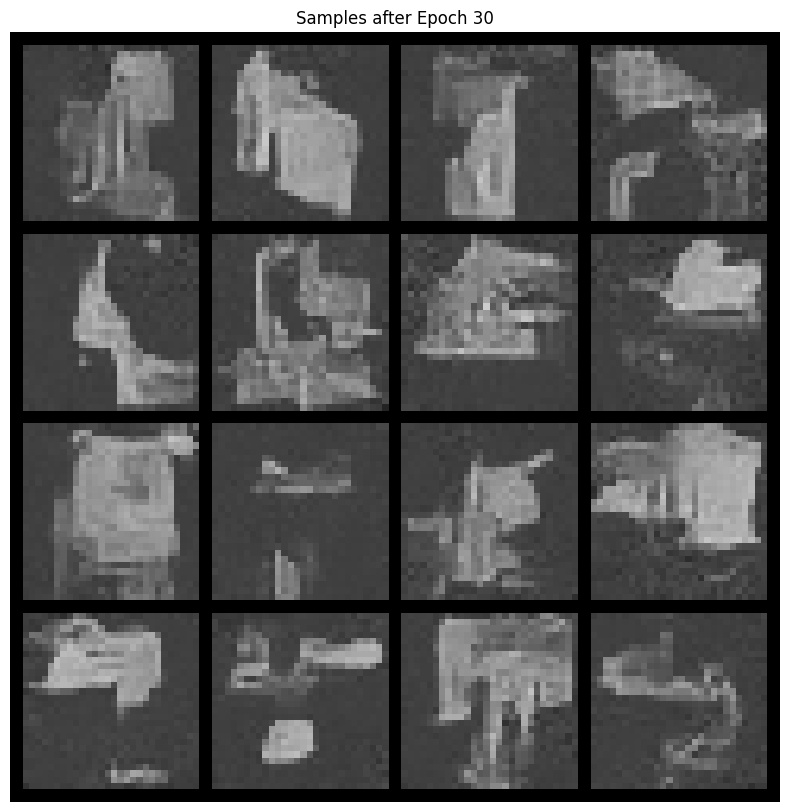

Epoch 31/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31/60, Loss: 0.033472


Epoch 32/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32/60, Loss: 0.033378


Epoch 33/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33/60, Loss: 0.033229


Epoch 34/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34/60, Loss: 0.033537


Epoch 35/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35/60, Loss: 0.033595


Epoch 36/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36/60, Loss: 0.033002


Epoch 37/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37/60, Loss: 0.033417


Epoch 38/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38/60, Loss: 0.032894


Epoch 39/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39/60, Loss: 0.033294


Epoch 40/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40/60, Loss: 0.033047


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

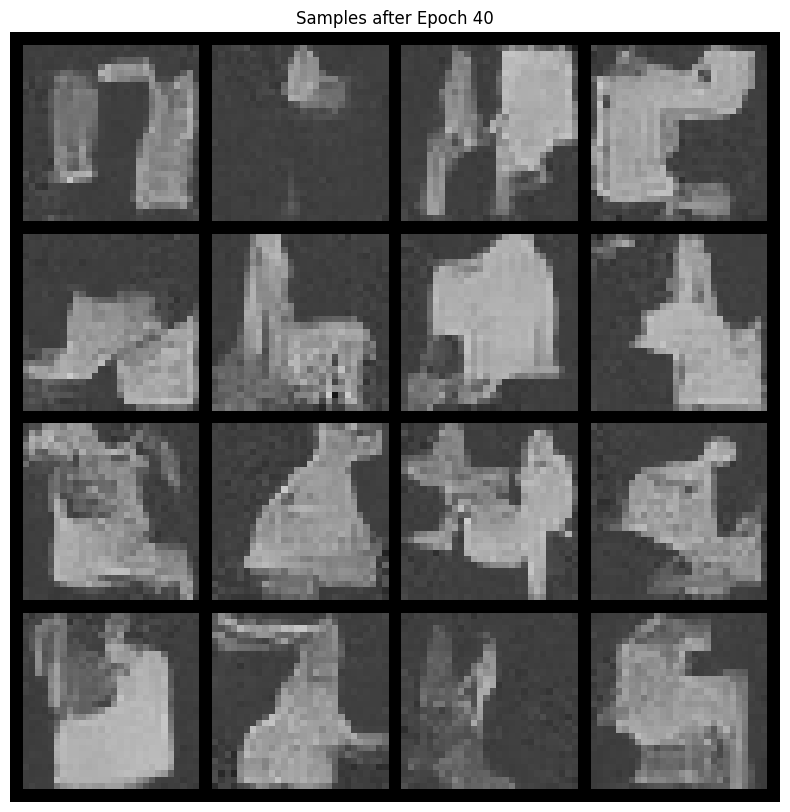

Epoch 41/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41/60, Loss: 0.032619


Epoch 42/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42/60, Loss: 0.032902


Epoch 43/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43/60, Loss: 0.032501


Epoch 44/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44/60, Loss: 0.032650


Epoch 45/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45/60, Loss: 0.033180


Epoch 46/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46/60, Loss: 0.032897


Epoch 47/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47/60, Loss: 0.032493


Epoch 48/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48/60, Loss: 0.032213


Epoch 49/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49/60, Loss: 0.032419


Epoch 50/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50/60, Loss: 0.032478


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

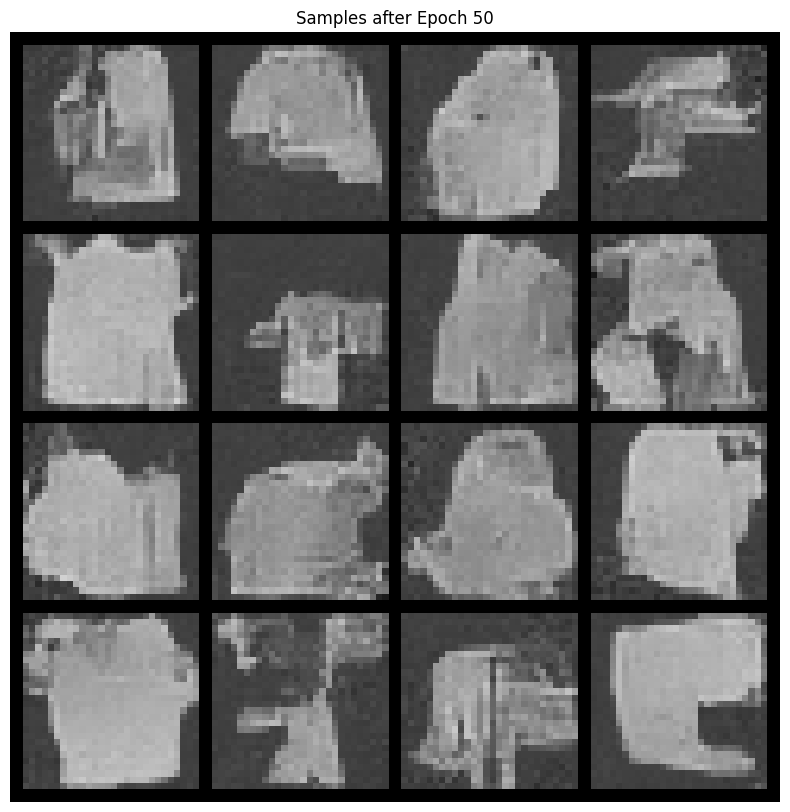

Epoch 51/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51/60, Loss: 0.032468


Epoch 52/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52/60, Loss: 0.032453


Epoch 53/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53/60, Loss: 0.032042


Epoch 54/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54/60, Loss: 0.032479


Epoch 55/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55/60, Loss: 0.032421


Epoch 56/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56/60, Loss: 0.032526


Epoch 57/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57/60, Loss: 0.032162


Epoch 58/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58/60, Loss: 0.032105


Epoch 59/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59/60, Loss: 0.032374


Epoch 60/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60/60, Loss: 0.032156


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

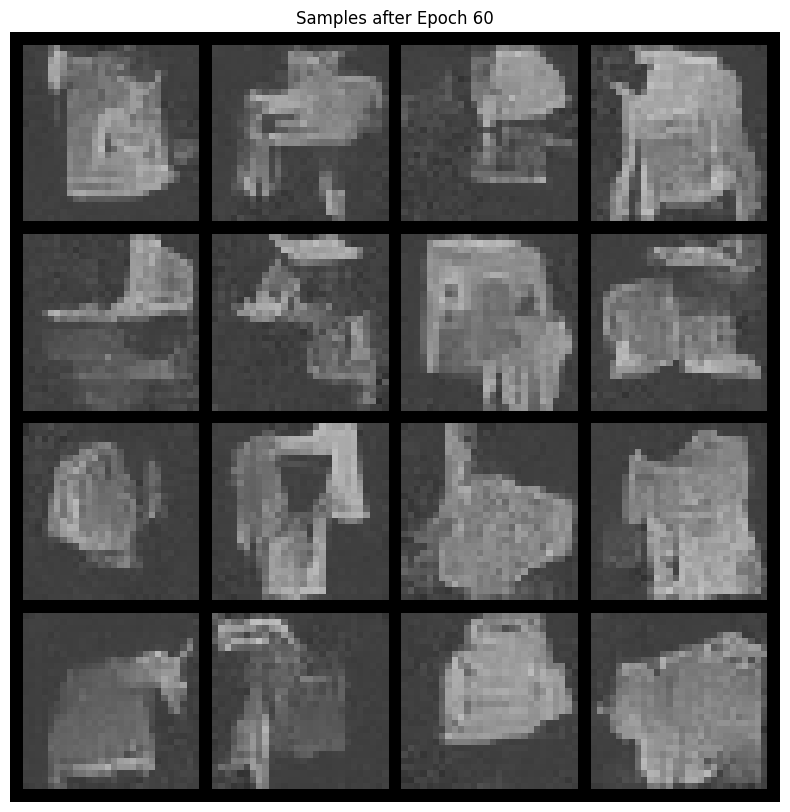

In [9]:
# ---------------------------------------------------
# Part 7: Train and Sample from the DDPM
# ---------------------------------------------------
# Initialize the DDPM model
ddpm = DDPM(
    eps_model=model,
    betas=(1e-4, 0.02),  # Start and end values for the noise schedule
    n_T=1000,           # Number of diffusion steps
).to(device)

# Optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

# Train the model (only a few epochs for the challenge)
def train_ddpm(model, dataloader, optimizer, n_epochs=10, plot_every=-1):
    """Train the DDPM model."""
    model.train()
    for epoch in range(n_epochs):
        # Use tqdm for a progress bar
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")
        epoch_loss = 0

        for batch, _ in pbar:
            batch = batch.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            loss = model(batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update progress bar
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        # Print epoch loss
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

        # Generate samples
        if plot_every > 0 and (epoch+1) % plot_every == 0:  # Generate samples every 2 epochs
            model.eval()
            with torch.no_grad():
                samples = model.sample(16, (1, 28, 28), device)
                show_images(samples, f"Samples after Epoch {epoch+1}")
            model.train()
train_ddpm(ddpm, train_loader, optimizer, n_epochs=60, plot_every=10)


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

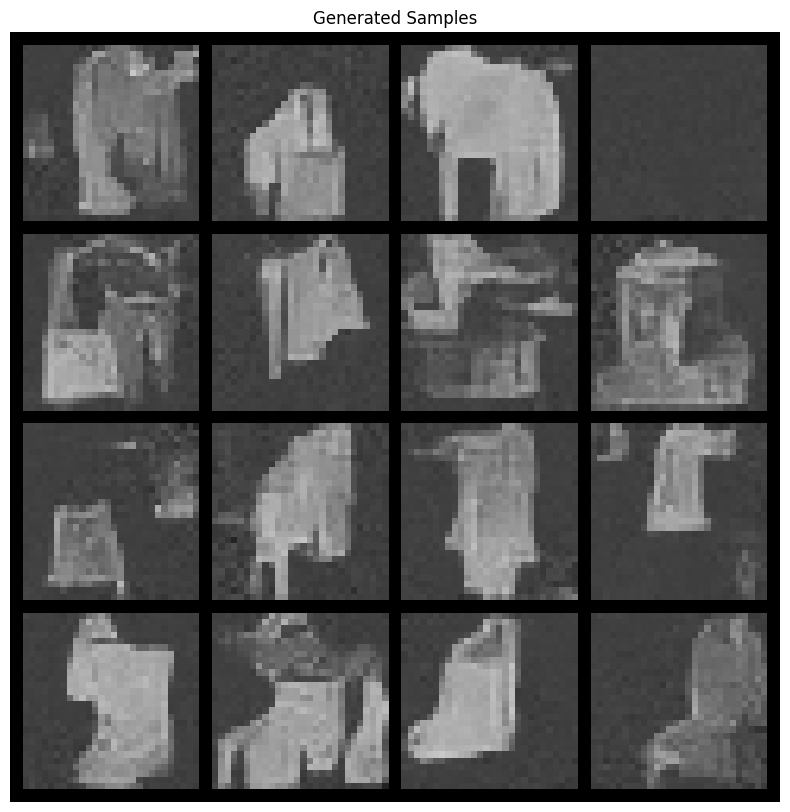

In [ ]:
# ---------------------------------------------------
# Part 8: Evaluate Your Model
# ---------------------------------------------------

def generate_samples(model, n_samples=16):
    """Generate new samples from the trained model."""
    model.eval()
    with torch.no_grad():
        samples, intermediate_steps = model.sample(n_samples, (1, 28, 28), device, return_intermediate_steps=True)
    return samples, intermediate_steps

samples, intermediate_steps = generate_samples(ddpm)
show_images(samples, "Generated Samples")


In [ ]:
def create_batch_slider(intermediate_steps, labels_list=None):
    """
    Create an interactive slider widget to browse through batches of images
    using the existing show_images function.

    Parameters:
    -----------
    intermediate_steps : list
        List of tensors, where each tensor contains a batch of images
    labels_list : list, optional
        List of label tensors corresponding to each batch of images

    Returns:
    --------
    None (displays the widget in the notebook)
    """
    import ipywidgets as widgets
    from IPython.display import display
    from IPython.display import clear_output

    # Create output area for displaying images
    output = widgets.Output()

    # Create slider widget for batch selection
    batch_slider = widgets.IntSlider(
        min=0,
        max=len(intermediate_steps)-1,
        step=1,
        value=len(intermediate_steps)-1,
        description='Denoising step:',
        continuous_update=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    # Function to display a batch using the existing show_images function
    def display_batch(step):
        with output:
            clear_output(wait=True)

            # Get current batch of images
            images = intermediate_steps[step]

            # Get corresponding labels if available
            labels = None
            if labels_list is not None and step < len(labels_list):
                labels = labels_list[step]

            # Call the existing show_images function
            show_images(images, title=f"Denoising Step {step + 1}/{len(intermediate_steps)}", labels=labels)

    # Update display when slider value changes
    def on_batch_change(change):
        display_batch(change['new'])

    batch_slider.observe(on_batch_change, names='value')

    # Show initial batch
    display_batch(batch_slider.value)

    # Add play button for slideshow
    play = widgets.Play(
        min=0,
        max=len(intermediate_steps)-1,
        step=10,
        value=len(intermediate_steps)-1,
        interval=1000,  # milliseconds between each frame
        description="Play",
        disabled=False
    )

    # Link play button with slider
    widgets.jslink((play, 'value'), (batch_slider, 'value'))

    # Create horizontal box with play button and slider
    controls = widgets.HBox([play, batch_slider])

    # Display controls and output
    display(widgets.VBox([controls, output]))


In [ ]:
create_batch_slider(intermediate_steps)

<h2>Measuring the quality of the generated images</h2>

In order to measure the quality of the generated images, we will use the Fréchet Inception Distance, a commonly used metric to evaluate the generated images against the original ones.


To do so, we will use an inception network (CNN network) to embed the images first and compare the two distributions of images (generated vs reel) using the Fréchet distance.

In [ ]:
import numpy as np
from scipy import linalg
import torch
from torch.nn.functional import adaptive_avg_pool2d
from torchvision.models import inception_v3

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate Fréchet Distance between two multivariate Gaussians."""
    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def get_activations(images, model, batch_size=50, dims=2048):
    """Get Inception activations for a batch of images."""
    model.eval()

    # Process images in batches to avoid memory issues
    n_batches = len(images) // batch_size + 1
    n_used_imgs = len(images)
    pred_arr = np.empty((n_used_imgs, dims))

    for i in range(n_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(images))
        if start >= end:
            break

        batch = images[start:end]
        with torch.no_grad():
            pred = model(batch)[0]

        # If model outputs a list, take the first element (features before classifier)
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))
        pred = pred.reshape(pred.shape[0], -1)
        pred_arr[start:end] = pred.cpu().numpy()

    return pred_arr

def calculate_fid(real_images, generated_images, batch_size=50, device='cuda'):
    """Calculate FID between real and generated images."""
    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()

    # Get activations
    real_activations = get_activations(real_images, inception_model, batch_size)
    gen_activations = get_activations(generated_images, inception_model, batch_size)

    # Calculate mean and covariance
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)

    mu_gen = np.mean(gen_activations, axis=0)
    sigma_gen = np.cov(gen_activations, rowvar=False)

    # Calculate FID
    fid_value = calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)

    return fid_value

# ---------------------------------------------------
# Part 9: Quiz
# ---------------------------------------------------

1. What is the primary difference between GANs and Diffusion Models?

2. In the forward diffusion process, what happens to the image as t increases?


3. What does the UNet model learn to predict in a DDPM?


4. Why do we use a schedule for beta values rather than a constant value?


5. How does the sampling (reverse diffusion) process generate a new image?


6. What's the significance of the parameter T (number of timesteps) in diffusion models?



<h1>Congratulations! You've completed the DDPM Challenge!</h1>